### Install needs

In [1]:
# pip install biopython bio networkx

### Imports

In [2]:
import os
# os.chdir("C:\\Users\\Ali Ahmadi\\Desktop\\RNA Secondary Structure Prediction\\notebook\\KH-99")

from collections import defaultdict
import matplotlib.pyplot as plt
from scipy.linalg import expm
from grammar.pcfg import PCFG
from copy import deepcopy
from Bio import Phylo
import networkx as nx
from math import log 
import numpy as np
import shutil

C:\Users\Ali Ahmadi\anaconda3\Lib\site-packages\Bio\Application\__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


### Stockholm to Phylip format conversion
https://www.hiv.lanl.gov/content/sequence/FORMAT_CONVERSION/form.html

### Get Maximum Likelihood phylogenetic tree
http://www.atgc-montpellier.fr/phyml/

### Get From files

##### Sequences

In [3]:
def read_sequences (filename: str):
    first_ln = False
    num_seq = 0
    len_seq = 0
    
    sequences = defaultdict(str)
    
    with open(filename) as file:
        for line in file:
            line = line.strip().split()
            if len(line) == 2:
                if first_ln == False:
                    num_seq = int(line[0])
                    len_seq = int(line[1])
                    first_ln = True
                else:
                    if len(line[1]) == len_seq and num_seq != 0:
                        sequences[line[0]] = line[1]
                        num_seq -= 1
                    else: 
                        raise ValueError("Invalid file structure")
    return sequences

##### Tree

In [4]:
def clade_names_fix(tree):
    for index, clade in enumerate(tree.find_clades()):
        if not clade.name:
            clade.name = str(index)

def read_tree(filename: str):
    Tree = Phylo.read(filename, 'newick')
    clade_names_fix(Tree)
    return Tree

##### Structure

In [5]:
def read_structure(filename: str):
    with open(filename) as file:
        return file.readline().strip()

In [6]:
def simplify_struct(structure: str, filename=""):
    pairing_chars = ["<", ">", "(", ")", "[", "]", "{", "}"]
    simplified = ""
    for i in range(len(structure)):
        if structure[i] in pairing_chars:
            simplified += "d "
        else:
            simplified += "s "
    if filename != "":        
        with open(f"{filename}.train", "w+") as file:
            file.write(simplified)
    
    return simplified

### Validate Sequence String

In [7]:
def is_valid_str(input_string, valid_characters = ["A", "C", "G", "U"]):
    for char in input_string:
        if char not in valid_characters:
            return False
    return True

### Get Pairing Charecter

In [8]:
def get_pair_start(pair_end):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return [val for val in pairing_chars if val[1] == pair_end][0][0]

In [9]:
def is_pair_start(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[0] for p in pairing_chars]

In [10]:
def is_pair_end(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[1] for p in pairing_chars]

### Estimate Tree

In [11]:
def create_tree(input_sequences, filename = "outputs\\tree.nwk", draw=True):
  names = list(input_sequences.keys())
  sequences = list(input_sequences.values())
  
  if len(names) <= 2:
    return None
  
  os.mkdir("tmp")

  if len(names) > 2:
    phylip_file = "tmp\\sequences.phylip"
    with open(phylip_file, "w") as f:
      f.write(f"{len(sequences)} {len(sequences[0])}\n\n")
      for i, seq in enumerate(sequences):
        f.write(f"{names[i]}\t{seq}\n") 
    
    !phyml -i tmp/sequences.phylip -m GTR
    
    output_tree = Phylo.read(phylip_file + "_phyml_tree.txt", 'newick')

    output_tree.root_at_midpoint()
  
  for index, clade in enumerate(output_tree.find_clades()):
    if not clade.name:
      clade.name = str(index)
  
  shutil.rmtree(".\\tmp")
  Phylo.write(output_tree, filename, "newick")
  
  if draw:
    Phylo.draw(output_tree)
  
  return output_tree

### Calculate frequency

In [12]:
def calc_frequencies (sequences: defaultdict, structure, known_chars = ["A", "C", "G", "U"]):
    single_nucleotides = defaultdict(int)
    paired_nucleotides = defaultdict(int)
    
    total_singles = 0
    total_paireds = 0
    
    # Stack of unpaired nucleotides (structure symbol, nocleotide)
    unpaired_nucleotides = []
    
    for _, sequence in sequences.items():
        for index, nucleotide in enumerate(sequence): 
            structure_symbol = structure[index]
            # Having a charecter [ '(', '[', '{', '<' ]
            if is_pair_start(structure_symbol):
                unpaired_nucleotides.append((structure_symbol, nucleotide))
            # Having a charecter [ ')', ']', '}', '>' ]
            elif is_pair_end(structure_symbol):
                unpaired_nucleotide = unpaired_nucleotides.pop()
                if unpaired_nucleotide[0] == get_pair_start(structure_symbol):
                    paired_nucleotide = unpaired_nucleotide[1] + nucleotide
                    if is_valid_str(paired_nucleotide, known_chars):
                        paired_nucleotides[paired_nucleotide] += 1
                        paired_nucleotides[paired_nucleotide[::-1]] += 1
                        total_paireds += 1
                else:
                    raise ValueError('Invalid pattern in structure')
            # Having a non-pairing charecter
            else:
                if is_valid_str(nucleotide, known_chars):
                    single_nucleotides[nucleotide] += 1
                    total_singles += 1

    total = total_singles + (total_paireds * 2)
                
    for key, value in single_nucleotides.items():
        single_nucleotides[key] = value / total_singles
    for key, value in paired_nucleotides.items():
        paired_nucleotides[key] = value / (total_paireds * 2)
        
    return (
        single_nucleotides,
        paired_nucleotides,
        total_singles / total,
        (total_paireds * 2) / total
    )

### Simularity Percentage

In [13]:
def check_simularity(seq1:str, seq2:str):
    simularity = 0
    if len(seq1) == len(seq2):
        for i in range(len(seq1)):
            if seq1[i] == seq2[i]:
                simularity += 1
        return simularity / len(seq1) >= .85

### Calculate Rate Matrix
$$r_{XY}=\frac{c_{XY}}{2p_xP_s\sum_{P} N_Pt_P}$$
$$r_{XY}=\frac{2c_{XY}}{2p_xP_s\sum_{P} N_Pt_P}$$

In [14]:
def calc_rate_values(
    graph,
    sequences: defaultdict, 
    structure, 
    single_frequencies, 
    paired_frequencies, 
    singles_prob, 
    paireds_prob, 
    known_chars = ["A", "C", "G", "U"]
):
    sequences_list = [(k, v) for k, v in sequences.items()]
    unpaired_nucleotides = []
    k_value = 0
    
    single_mutation_count = defaultdict(float)
    paired_mutation_count = defaultdict(float)
    
    for i in range(len(sequences_list)):
        temp_single_mutation_count = defaultdict(int)
        temp_paired_mutation_count = defaultdict(int)
        
        same_first_sequence_count = 0
        
        for j in range(len(sequences_list)):
            columns_count = 0
            differs_count = 0
            
            first_name = sequences_list[i][0]
            second_name = sequences_list[j][0]
            first_sequence = sequences_list[i][1]
            second_sequence = sequences_list[j][1]
            # The pair should contain diffrent 
            # sequence with at least %85 simularity.
            if i != j and check_simularity(first_sequence, second_sequence):
                same_first_sequence_count += 1
                for k in range(len(first_sequence)): 
                    structure_symbol = structure[k]
                    # Having a charecter [ '(', '[', '{', '<' ]
                    if is_pair_start(structure_symbol):
                        unpaired_nucleotides.append((
                            structure_symbol, 
                            first_sequence[k], 
                            second_sequence[k]
                        ))
                    # Having a charecter [ ')', ']', '}', '>' ]
                    elif is_pair_end(structure_symbol):
                        unpaired_nucleotide = unpaired_nucleotides.pop()
                        first_pair = unpaired_nucleotide[1] + first_sequence[k]
                        second_pair = unpaired_nucleotide[2] + second_sequence[k]
                        if unpaired_nucleotide[0] == get_pair_start(structure_symbol):
                            if (is_valid_str(first_pair, known_chars) 
                            and is_valid_str(second_pair, known_chars)):
                                columns_count += 2
                                if first_pair != second_pair:
                                    differs_count += 2
                                    temp_paired_mutation_count[(first_pair, second_pair)] += 1
                                    temp_paired_mutation_count[(first_pair[::-1], second_pair[::-1])] += 1
                        else:
                            raise ValueError('Invalid pattern in structure')    
                    # Having a non-pairing charecter
                    else:
                        if (is_valid_str(first_sequence[k], known_chars) 
                        and is_valid_str(second_sequence[k], known_chars)):
                            columns_count += 1
                            if first_sequence[k] != second_sequence[k]:
                                differs_count += 1
                                
                                temp_single_mutation_count[(
                                    first_sequence[k], 
                                    second_sequence[k],
                                )] += 1
                
                k_value += (graph.distance(
                    first_name, 
                    second_name
                ) * columns_count)
                # k_value += ((differs_count / columns_count) * columns_count)
        
        if same_first_sequence_count > 0:
            for key in temp_single_mutation_count:
                single_mutation_count[key] += (temp_single_mutation_count[key] 
                                               / same_first_sequence_count)
            for key in temp_paired_mutation_count:
                paired_mutation_count[key] += (temp_paired_mutation_count[key] 
                                               / same_first_sequence_count)
                
    single_chars = known_chars
    paired_chars = [c1 + c2 for c1 in single_chars for c2 in single_chars]
    
    single_rate_values = defaultdict(float)
    paired_rate_values = defaultdict(float)
            
    for i in single_chars:
        single_rate_values[(i,i)] = 0
        for j in single_chars:
            if i != j:
                single_rate_values[(i,j)] = (single_mutation_count[(i,j)] 
                                             / (singles_prob * single_frequencies[i] * k_value))
                single_rate_values[(i,i)] = single_rate_values[(i,i)] - single_rate_values[(i,j)]

    for i in paired_chars:
        paired_rate_values[(i,i)] = 0
        for j in paired_chars:
            if i != j:
                paired_rate_values[(i,j)] = ((paired_mutation_count[(i,j)] * 2)
                                             / (paireds_prob * paired_frequencies[i] * k_value))
                paired_rate_values[(i,i)] = paired_rate_values[(i,i)] - paired_rate_values[(i,j)]
    
    return single_rate_values, paired_rate_values  

### probability matrix From Q matrix

$$P = e^{Qt}$$

In [15]:
def get_mutation_probablities(mutation_rate_values, time, order_array = ["A", "C", "G", "U"]):
    mutation_rate_matrix = np.zeros((len(order_array), len(order_array)), np.float64)
    
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            mutation_rate_matrix[i_index,j_index] = mutation_rate_values[(i_value, j_value)]
    
    probability_rate_matrix = expm(mutation_rate_matrix * time)
    
    probability_rate_values = defaultdict(float)
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            probability_rate_values[(i_value, j_value)] = probability_rate_matrix[i_index,j_index]
    
    return probability_rate_values

### Get columns probability

In [16]:
def pattern_successor(pattern):
    order = ["A", "C", "G", "U"]
    last_filled = len(pattern) - 1
    gap_shifted = False

    for i in range(len(pattern)):
        if pattern[i] != "-":
            if pattern[i] == order[-1]:
                pattern[i] = order[0]
            else:
                index = order.index(pattern[i])
                pattern[i] = order[index + 1]
                return pattern
    
    indices = [i for i, x in enumerate(pattern) if x == '-']
    
    for index in indices[::-1]:
        if index == last_filled and pattern[index] == "-":
            last_filled -= 1
            pattern[index] = order[0]
            continue
        elif index != last_filled and pattern[index] == "-":
            pattern[index] = order[0]
            for shifte in range(len(pattern) - last_filled):
                pattern[(index + shifte + 1)] = "-"
            gap_shifted = True
            break
    
    if not gap_shifted:
        if (len(pattern) - last_filled) == (len(pattern) + 1):
            return []
        else:
            for index in range(len(pattern) - last_filled):
                pattern[index] = "-"
    
    return pattern

In [17]:
def add_gap_probablities(columns_probability, height, paired = False):
    pattern = (["U"] * height * 2) if paired else (["U"] * height)
    
    while pattern_successor(pattern) != []:
        index = pattern.index("-")
        order = ["A", "C", "G", "U"]
        probability = 0
        for n in order:
            pattern[index] = n
            if paired:
                    probability += columns_probability[tuple([
                        pattern[i] + pattern[i+1] for i in range(0, len(pattern), 2)
                    ])]
            else:
                probability += columns_probability[tuple(pattern)]
        pattern[index] = "-"
        
        if paired:
            columns_probability[tuple([
                pattern[i] + pattern[i+1] for i in range(0, len(pattern), 2)
            ])] = probability
            
        else:
            columns_probability[tuple(pattern)] = probability
    columns_probability

In [18]:
def post_order_traversal(tree, current_node, possible_values, rate_values, leaf_order = []): 
    current_columns_probability = defaultdict(lambda: defaultdict(float))
    
    for child in current_node.clades:
        # going to add a branch with a single nucleotide 
        if child.is_terminal():
            leaf_order.append(child.name)
            
            time = tree.distance(
                current_node.name, 
                child.name
            )
            mutation_probablities = get_mutation_probablities(rate_values, time, possible_values)
            
            # have filled with some branch in last iteration
            if current_columns_probability:
                perv_columns_probability = deepcopy(current_columns_probability)
                current_columns_probability.clear()
                
                for left_column in perv_columns_probability:
                    for root in perv_columns_probability[left_column]:
                        for child_value in possible_values:
                            current_columns_probability[left_column + (child_value ,)][root] = (
                                mutation_probablities[(root, child_value)] * 
                                perv_columns_probability[left_column][root]
                            )
                perv_columns_probability.clear()
            
            # haven't filled with any branch in last iteration
            else:
                for mutation in mutation_probablities:
                    current_columns_probability[(mutation[1] ,)][mutation[0]] = mutation_probablities[mutation]
        # going to add a branch with a more than one nucleotide 
        else:    
            inner_columns_probability, _ = post_order_traversal(tree, child, possible_values, rate_values, leaf_order)
            
            time = tree.distance(
                current_node.name, 
                child.name
            )
            mutation_probablities = get_mutation_probablities(rate_values, time, possible_values)
            
            # have filled with some branch in last iteration
            if current_columns_probability:
                perv_columns_probability = deepcopy(current_columns_probability)
                current_columns_probability.clear()
                
                for left_column in perv_columns_probability:
                    for root in perv_columns_probability[left_column]:
                        for right_column in inner_columns_probability:
                            current_columns_probability[left_column + right_column][root] = sum(
                                (
                                    mutation_probablities[(root, inner_root)] * 
                                    inner_columns_probability[right_column][inner_root] * 
                                    perv_columns_probability[left_column][root]
                                ) for inner_root in inner_columns_probability[right_column])
                
                perv_columns_probability.clear()

            # haven't filled with some branch in last iteration
            else:
                for root_value in possible_values:
                    for column in inner_columns_probability:
                        current_columns_probability[column][root_value] = sum(
                            (
                                mutation_probablities[(root_value, inner_root)] * 
                                inner_columns_probability[column][inner_root]
                            ) for inner_root in inner_columns_probability[column]
                        )
                    
    return current_columns_probability, leaf_order

In [19]:
def get_columns_probability(
    tree,  
    single_frequencies, 
    paired_frequencies, 
    single_rate_values, 
    paired_rate_values,
):
    single_possible_values = ['A', 'C', 'G', 'U']
    paired_possible_values = [c1 + c2 for c1 in single_possible_values for c2 in single_possible_values]
    
    __single_columns_probability, leaf_order = post_order_traversal(
        tree, 
        tree.root, 
        single_possible_values, 
        single_rate_values,
        []
    )
    single_columns_probability = defaultdict(float)
    for column in __single_columns_probability:
        single_columns_probability[column] = sum(
            __single_columns_probability[column][root] 
            * single_frequencies[root] for root in single_possible_values
        )
    __single_columns_probability.clear()
    
    __paired_columns_probability, _ = post_order_traversal(
        tree, 
        tree.root, 
        paired_possible_values, 
        paired_rate_values, 
        []
    )
    paired_columns_probability = defaultdict(float)
    for column in __paired_columns_probability:
        paired_columns_probability[column] = sum(
            __paired_columns_probability[column][root] 
            * paired_frequencies[root] for root in paired_possible_values
        )
    __paired_columns_probability.clear()
    
    add_gap_probablities(single_columns_probability, tree.count_terminals(), paired=False)
    add_gap_probablities(paired_columns_probability, tree.count_terminals(), paired=True)
    
    return single_columns_probability, paired_columns_probability, leaf_order

### Save PCFG

In [20]:
def save_pcfg(pcfg, filename):
    unary_rules = pcfg.grammar.unary_rules
    binary_rules = pcfg.grammar.binary_rules
    
    with open(f"{filename}.pcfg", "w+") as pcfg_file:
        for A, B, C in binary_rules:
            pcfg_file.write(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}\n")
            
        for A, w in unary_rules:
            pcfg_file.write(f"{A} -> {w} {pcfg.q[(A, w)]}\n")

### Extend grammar

In [21]:
def extend_grammar(
    columns,
    pcfg,
    single_column_probs, 
    paired_column_probs,
    filename="Extended"
):
    unary_rules = pcfg.grammar.unary_rules
    binary_rules = pcfg.grammar.binary_rules
    
    with (open(f"{filename}.pcfg", "w+") as pcfg_file, open(f"{filename}.cfg", "w+") as cfg_file):
        for A, B, C in binary_rules:
            if A == "Dm" and B == "Dl" and C == "F":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A+term} -> Dl{term} F {pcfg.q[(A, B, C)]}" + "\n")
                        cfg_file.write(f"{A+term} -> Dl{term} F" + "\n")
            elif B == "Dm" and C == "Dr":
                for column, prob in paired_column_probs.items():
                    left_column = tuple(
                        pair[0] for pair in column if pair
                    )
                    right_column = tuple(
                        pair[1] for pair in column if pair
                    )
                    if columns.get(left_column, False) and columns.get(right_column, False):
                        left_term = str(left_column).replace(" ", "")
                        right_term = str(right_column).replace(" ", "")
                        pcfg_file.write(f"{A} -> Dm{left_term} Dr{right_term} {pcfg.q[(A, B, C)] * prob}" + "\n")
                        cfg_file.write(f"{A} -> Dm{left_term} Dr{right_term}" + "\n")
            else:
                pcfg_file.write(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}" + "\n")
                cfg_file.write(f"{A} -> {B} {C}" + "\n")

        for A, w in unary_rules:
            if w == "s":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A} -> {term} {pcfg.q[(A, w)] * prob}" + "\n")
                        cfg_file.write(f"{A} -> {term}" + "\n")
            elif w == "d":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):      
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A+term} -> {term} {pcfg.q[(A, w)]}" + "\n")
                        cfg_file.write(f"{A+term} -> {term}" + "\n")
            else:
                pcfg_file.write(f"{A} -> {w} {pcfg.q[(A, w)]}" + "\n")
                cfg_file.write(f"{A} -> {w}" + "\n")

### Get CYK tree

In [22]:
predicted_struct = {}

def gen_parse_tree(tree, table, start, end, non_terminal = "S", firstRun = True, layer=1):
    if firstRun:
        tree.add_node((start, end, "S"), layer=layer)
        layer += 1
        
    if start == end and table[(start, end, non_terminal)]:
        if non_terminal.startswith("Dl"):
            predicted_struct[start] = "("
        elif non_terminal.startswith("Dr"):
            predicted_struct[start] = ")"
        else:
            predicted_struct[start] = "."

    for _start, _end, _non_terminal in table[(start, end, non_terminal)]:
        tree.add_node((_start, _end, _non_terminal), layer=layer)
        new_layer = layer + 1
        tree.add_edge((_start, _end, _non_terminal), (start, end, non_terminal))
        gen_parse_tree(tree, table, _start, _end, _non_terminal, firstRun=False, layer=new_layer)

In [23]:
def draw_parse_tree(table, start_point, end_point):
    parse_tree = nx.Graph()
    
    gen_parse_tree(parse_tree, table, start_point, end_point)
    
    pos = nx.multipartite_layout(parse_tree, subset_key ="layer")
    nx.draw(
        parse_tree, 
        pos, 
        # with_labels=True, 
        node_color='#74b9ff', 
        node_size=50, 
        font_size=10
    )
    nx.draw_networkx_nodes(
        parse_tree, 
        pos, 
        nodelist=[(start_point, end_point, "S")], 
        node_color='#0984e3', 
        node_size=50
    )

### Get total sequence

In [24]:
def get_total_sequence(input_sequences, leaf_order):
    total_sequence = ""
    columns = defaultdict(bool)
    for i in range(len(list(input_sequences.values())[0])):
        column = tuple([
            input_sequences[name][i] for name in leaf_order
        ])
        columns[column] = True
        total_sequence += str(column).replace(" ", "") + " "
    return total_sequence, columns

# Test

### Calculate mutation rate and frequencies

In [25]:
sequences = read_sequences("primaries\\RF03000.phylip")

In [26]:
# estimated_tree = create_tree(sequences, "primaries\\RF03000.nwk", draw=False)

In [27]:
primary_tree = read_tree("primaries\\RF03000.nwk")

In [28]:
structure = read_structure("primaries\\RF03000.structure")
simplified = simplify_struct(structure, "primaries\\RF03000")

(single_frequencies, 
 paired_frequencies, 
 singles_prob, 
 paireds_prob) = calc_frequencies(sequences, structure)

(single_rate_values, 
 paired_rate_values) = calc_rate_values(
    primary_tree,
    sequences, 
    structure, 
    single_frequencies, 
    paired_frequencies, 
    singles_prob, 
    paireds_prob
)

### Estimate PCFG on structure 

In [29]:
# Train for first time
# pcfg = PCFG("primaries\\Structure.cfg")
# pcfg.estimate("primaries\\RF03000.train", iter_num=20)
# save_pcfg(pcfg, "primaries\\Structure")

In [30]:
# Read from trained file
pcfg = PCFG("primaries\\Structure.cfg", "primaries\\Structure.pcfg")

### Calculat probablities
example: 


`Seq1`: `GGGCCUGUAGCUCAGAGGAUUAGAGCACGUGGCUACGAACCACGGUGUCGGGGGUUCGAAUCCCUCCUCGCCCA`<br />
`Seq2`: `GGGCUAUUAGCUCAGUUGGUUAGAGCGCACCCCUGAUAAGGGUGAGGUCGCUGAUUCGAAUUCAGCAUAGCCCA`<br />
`Seq3`: `GGCGCCGUGGCGCAGUGGA--AGCGCGCAGGGCUCAUAACCCUGAUGUCCUCGGAUCGAAACCGAGCGGCGCUA`

`RNAalifold`: `(((((((..((((.........)))).(((((.......))))).....(((((.......)))))))))))).`<br />
`Prediction`: `(((((((..((((.........))))((((((.......))))))....(((((.......)))))))))))).`








                                 ..........................                                      
 ooooooooooooooooooooooooooooo        CURRENT SETTINGS        ooooooooooooooooooooooooooooooooooo
                                 ..........................                                      

                . Sequence filename:				 sequences.phylip
                . Data type:					 dna
                . Alphabet size:				 4
                . Sequence format:				 interleaved
                . Number of data sets:				 1
                . Nb of bootstrapped data sets:			 0
                . Compute approximate likelihood ratio test:	 yes (SH-like branch supports)
                . Model name:					 GTR
                . Proportion of invariable sites:		 0.000000
                . Number of subst. rate categs:			 4
                . Gamma distribution parameter:			 estimated
                . 'Middle' of each rate class:			 mean
                . Nucleotide equilibrium frequencies:	

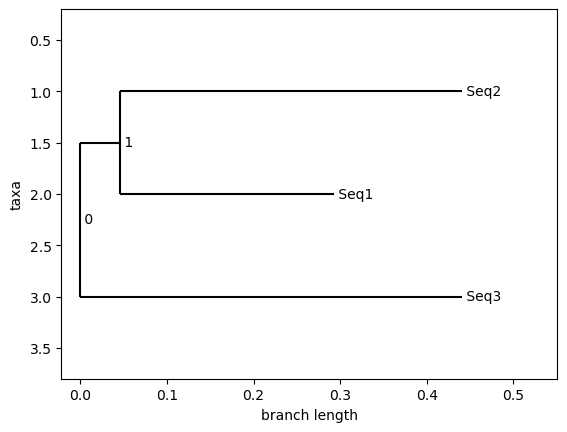

In [31]:
input_sequences = {
    "Seq1": "GGGCCUGUAGCUCAGAGGAUUAGAGCACGUGGCUACGAACCACGGUGUCGGGGGUUCGAAUCCCUCCUCGCCCA",
    "Seq2": "GGGCUAUUAGCUCAGUUGGUUAGAGCGCACCCCUGAUAAGGGUGAGGUCGCUGAUUCGAAUUCAGCAUAGCCCA",
    "Seq3": "GGCGCCGUGGCGCAGUGGA--AGCGCGCAGGGCUCAUAACCCUGAUGUCCUCGGAUCGAAACCGAGCGGCGCUA",
}

estimated_tree = create_tree(input_sequences)
(
    single_columns_probability, 
    paired_columns_probability,
    leaf_order,
) = get_columns_probability(
    estimated_tree,
    single_frequencies, 
    paired_frequencies, 
    single_rate_values, 
    paired_rate_values
)

In [32]:
total_sequence, columns = get_total_sequence(input_sequences, leaf_order)

extend_grammar(
    columns,
    pcfg,
    single_columns_probability, 
    paired_columns_probability,
    filename="outputs\\Extended"
)

In [33]:
# Read from extended file
extended_pcfg = PCFG("outputs\\Extended.cfg", "outputs\\Extended.pcfg")

In [34]:
# Run CYK algorithm
prob, table = extended_pcfg.sentence_prob(total_sequence)
print("Alignment probability:", prob)

Alignment probability: 9.320209445220597e-105


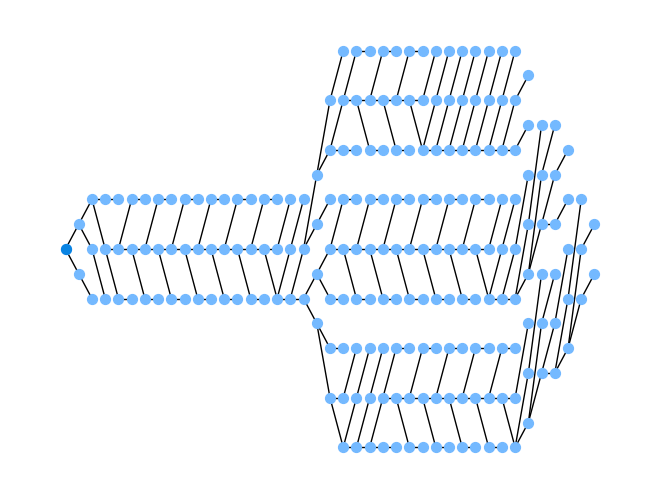

In [35]:
# Go throw parse table
draw_parse_tree(table, 1, len(list(input_sequences.values())[0]))
plt.savefig("plot.png", dpi=1000)

In [36]:
struct = ""
for key, val in predicted_struct.items():
    struct += val
print("Predicted Structure:",struct)

Predicted Structure: (((((((..((((.........))))((((((.......))))))....(((((.......)))))))))))).
